# Preprocessing Bren oil price historical data

### Add project path to system path

In [1]:
import pandas as pd
import os
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Import modules

In [2]:
from script.preprocessing_and_EDA import Preprocessor
preprocessor=Preprocessor()

### Load Data

In [3]:
brent_oil_price_data=preprocessor.load_data()
brent_oil_price_data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


### Load data sets

In [4]:
preprocessor.data_overview(brent_oil_price_data)

Number of rows:9011
Number of columns:2
Data types of each column:
Date      object
Price    float64
dtype: object


## Check missing data

In [5]:
preprocessor.check_missing(brent_oil_price_data)

Date     0
Price    0
dtype: int64

### Convert to date-time format

In [6]:
preprocessor.convert_to_datetime(brent_oil_price_data)
brent_oil_price_data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


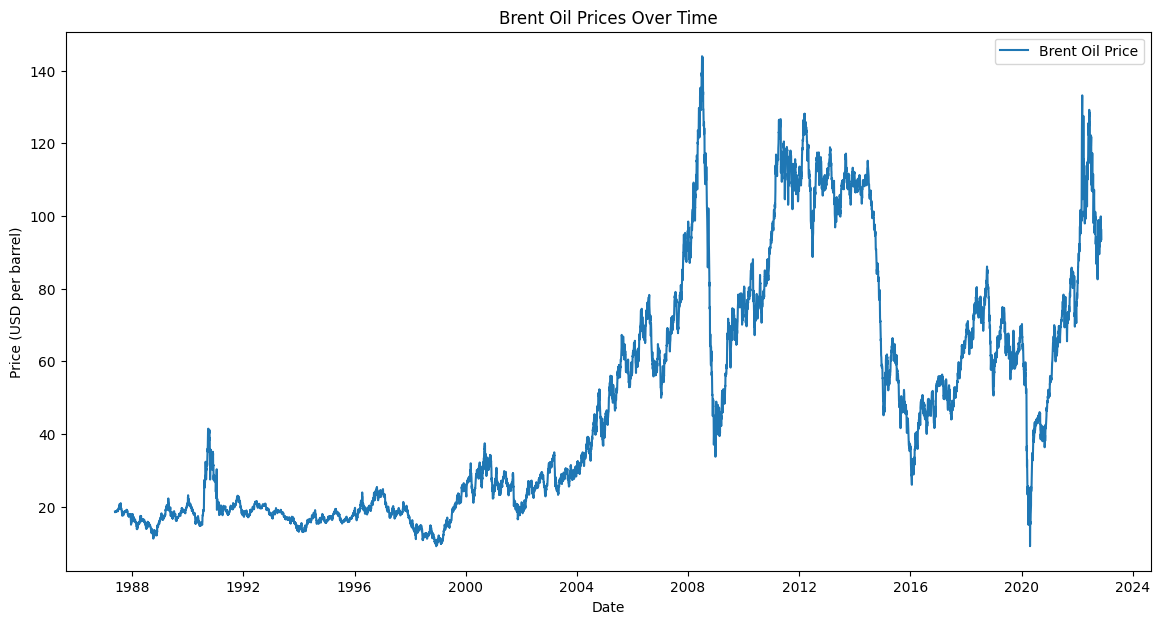

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
# brent_oil_price_data.set_index('Date', inplace=True)
plt.plot(brent_oil_price_data['Price'], label='Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Brent Oil Prices Over Time')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import ruptures as rpt
from scipy.stats import zscore
df=brent_oil_price_data

# Load your data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Price'], label='Price')
plt.title("Time Series Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
with pm.Model() as model:
    # Priors for the rate of change before and after changepoint
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    
    # Changepoint
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(df)-1)

    # Observed data likelihood, where mean shifts after tau
    idx = np.arange(len(df))
    mu = pm.math.switch(tau > idx, alpha, beta)
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=zscore(df["Price"]))

    # Sample the posterior
    trace = pm.sample(1000, return_inferencedata=True)
    
# Plot posterior distribution of changepoint
pm.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior Distribution of Changepoint (Bayesian)")
plt.show()


In [ ]:
# Prepare the data for changepoint detection (z-scored for scaling)
price_series = zscore(df["Price"].values)

# Use Binseg for changepoint detection
model = "l2"  # model type, l2 for least-squares
algo = rpt.Binseg(model=model).fit(price_series)
breakpoints = algo.predict(n_bkps=3)  # specify the number of changepoints

# Plot the results with detected changepoints
plt.figure(figsize=(10, 6))
plt.plot(df.index, price_series, label='Price')
for bkpt in breakpoints:
    plt.axvline(df.index[bkpt], color="red", linestyle="--", label='Changepoint')
plt.title("Changepoint Detection using Ruptures")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12, 8))

# Plot the original data
plt.plot(df.index, df['Price'], label='Price')

# Plot ruptures detected changepoints
for bkpt in breakpoints:
    plt.axvline(df.index[bkpt], color="blue", linestyle="--", label='Ruptures Changepoint')

# Plot Bayesian changepoint from pymc
changepoint = int(np.mean(trace.posterior['tau'].values))
plt.axvline(df.index[changepoint], color="green", linestyle="--", label='Bayesian Changepoint')

plt.title("Changepoint Detection with pymc and ruptures")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
